# Construction d’un RBM et test sur Binary AlphaDigits

### Data and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.utils import shuffle
FILE = loadmat('binaryalphadigs.mat')

### Initiliztion of the RBM's weights and bias

In [2]:
def init_RBM(p,q):
    RBM = {} 
    RBM['a'] = np.zeros((1,p))
    RBM['b'] = np.zeros((1,q))
    RBM['w'] = 0.01 * np.random.rand(p,q)
    
    return RBM

### Convert input data to matrix

In [3]:
def lire_alpha_digit(FILE_dat, idx):
     
    imgs = FILE_dat[idx,:].flatten()
    imgs_flatten = []
    for img in imgs:
        imgs_flatten.append(img.flatten())
    
    return np.array(imgs_flatten)

### Get output values using an RBM structure and input data

In [4]:
def entree_sortie_RBM(RBM, donnee):
    
    b = RBM['b'].reshape(1,-1)
    w = RBM['w']
    n = donnee.shape[0]
    sortie = 1 / (1 + np.exp(- b - donnee @ w ))
    
    return sortie

### Get input values using and RBM structure and output data

In [5]:
def sortie_entree_RBM(RBM, donnee):
    
    a = RBM['a'].reshape(1,-1)
    w = RBM['w']
    n = donnee.shape[0]
    entree = 1 / (1 + np.exp(- a - donnee @ w.T))
                  
    return entree

### Using Contrastive-Divergence-1 to train the RBM (unsupervised learning):

### Details [here](http://deeplearning.net/tutorial/rbm.html)

In [6]:
from tqdm import tqdm
def train_RBM(RBM, donnee, n_hidden, n_iteration, learning_rate, size_batch):
    
    loss   = np.zeros(n_iteration)
    donnee = shuffle(donnee)
    n      = donnee.shape[0]
    q      = n_hidden
    p      = donnee.shape[1]
    
    for i in range(n_iteration):    
        for batch in np.arange(0, n, size_batch):
            
            index_batch = np.arange(batch, min(batch + size_batch,n))
            x = donnee[index_batch,:]
        
            # tirage monte carlo
            v_0   = x
            p_hv0 = entree_sortie_RBM(RBM, v_0)
            h_0   = (np.random.rand(v_0.shape[0], q) < p_hv0).astype('float')
            p_vh0 = sortie_entree_RBM(RBM, h_0)
            v_1   = (np.random.rand(v_0.shape[0], p) < p_vh0).astype('float')
            p_hv1 = entree_sortie_RBM(RBM, v_1)
            
            # calcul gradient
            d_a = np.sum(v_0 - v_1, axis=0) / v_0.shape[0]
            d_b = np.sum(p_hv0 - p_hv1, axis=0) / v_0.shape[0]
            d_W = (v_0.T @ p_hv0 - v_1.T @ p_hv1) / v_0.shape[0] # produit vectoriel

            # mise a jour
            RBM['a'] = RBM['a'] + learning_rate * d_a
            RBM['b'] = RBM['b'] + learning_rate * d_b
            RBM['w'] = RBM['w'] + learning_rate * d_W
            
        sortie = entree_sortie_RBM(RBM, donnee)
        
        entree_reconstruite = sortie_entree_RBM(RBM, sortie)

        loss[i] = np.sum((entree_reconstruite - donnee)**2)/(n*p)
        
    return RBM, loss

### Generate samples of images from the RBM using Gibbs sampling:

In [7]:
def generer_image(RBM, n_image, n_iteration, string):
    
    p = RBM["w"].shape[0]
    q = RBM["w"].shape[1]
    plt.figure(figsize=(20,10))
    for i in range(n_image):
        v = (np.random.rand(p) < 0.5).astype('float')
        for j in range(n_iteration):
            h = (np.random.rand(q) < entree_sortie_RBM(RBM, v)).astype('float')
            v = (np.random.rand(p) < sortie_entree_RBM(RBM, h)).astype('float')
        
        plt.subplot(int(n_image/5),5,i+1)
        plt.imshow(1-v.reshape(20,16),cmap='gray')
        plt.axis('off')
    plt.suptitle(string)
    plt.show()
        

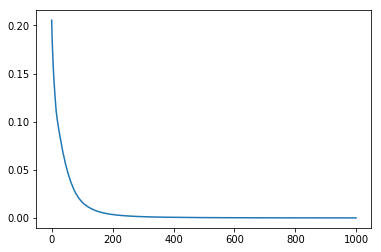

In [8]:
# Hyper-parameters settings and training

index         = [10,11,12]
donnee        = lire_alpha_digit(FILE['dat'], index)
n_hidden      = 200
n_iteration   = 1000
learning_rate = 0.1
size_batch    = 10
RBM           = init_RBM(donnee.shape[1], n_hidden)
RBM, loss     = train_RBM(RBM, donnee, n_hidden, n_iteration, learning_rate, size_batch)

plt.plot(loss)
plt.show()

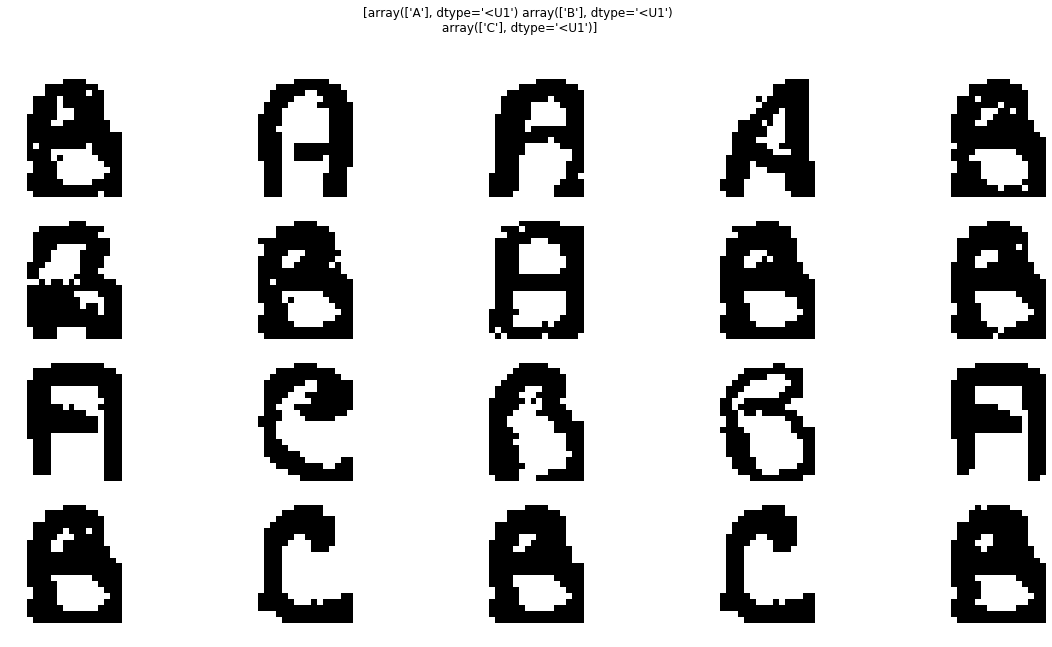

In [9]:
# Images sampling
n_iteration = 1000
n_image = 20
generer_image(RBM, n_image, n_iteration, str(FILE['classlabels'][0,index]))

# Construction d’un DBN et test sur Binary AlphaDigits

### Initiliztion of the DBN weights and bias


In [10]:
def init_DBN(layers):
    n_hs = [layers[0]]        
    DBN = []
    n_layer=0
    for n_h in layers[1:]:
        n_layer+=1
        rbm =init_RBM(n_hs[n_layer-1], n_h)
        n_hs.append(n_h) 
        DBN.append(rbm)
    return DBN

In [11]:
def train_DBN(DBN, donnee, n_iteration, learning_rate, size_batch):
  X=donnee
  n_layer=len(DBN)
  n  = donnee.shape[0]
  loss=np.zeros((n_layer,n_iteration))
  for layer in range(n_layer):
    print("Layer : " +str(layer+1))
    n_hidden=DBN[layer]["w"].shape[1]
    DBN[layer],_=train_RBM(DBN[layer], X, n_hidden, n_iteration, learning_rate, size_batch)
    X=entree_sortie_RBM(DBN[layer], X)

  return DBN

In [12]:
DBN=init_DBN([320,200,200])
donnee        = lire_alpha_digit(FILE['dat'], index)
n_iteration   = 200
learning_rate = 0.1
size_batch    = 10
DBN=train_DBN(DBN, donnee, n_iteration, learning_rate, size_batch)

Layer : 1
Layer : 2


In [13]:
def generer_image_DBN(DBN, n_image, n_iteration, string):

    p = DBN[0]["w"].shape[0]
    q = DBN[0]["w"].shape[1]

    n_layer=len(DBN)
    h_layer = n_layer - 1
    plt.figure(figsize=(20,10))
    for j in range(n_image):
        v = (np.random.rand(p) < 0.5).astype('float')
        for k in range(n_iteration):
          for i in range(n_layer):
              v =entree_sortie_RBM(DBN[i], v)  
              v = np.random.binomial(1, v, size=v.shape)                  
          for i in reversed(range(n_layer)):
              v =sortie_entree_RBM(DBN[i], v) 
              v = np.random.binomial(1, v, size=v.shape) 
        
        v = np.random.binomial(1, v, size=v.shape) 
        plt.subplot(int(n_image/5),5,j+1)
        plt.imshow(1-v.reshape(20,16),cmap='gray')
        plt.axis('off')
        
    plt.suptitle(string)
    plt.show()
        

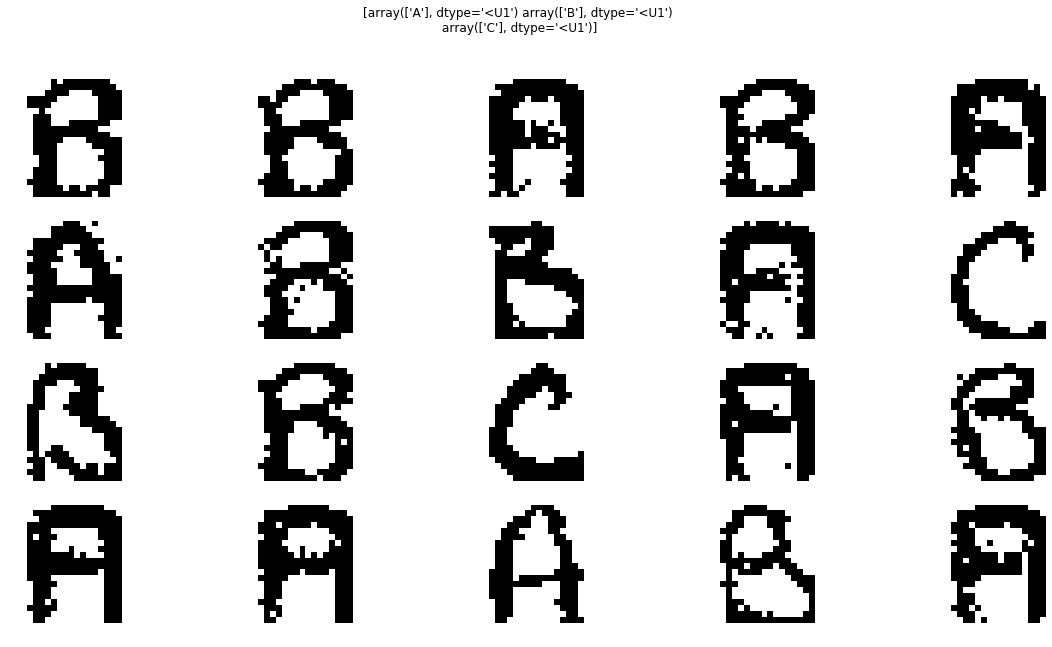

In [14]:
# Images sampling
n_iteration = 1000
n_image = 20
generer_image_DBN(DBN, n_image, n_iteration, str(FILE['classlabels'][0,index]))

## Construction d’un DNN et test sur MNIST

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [16]:
def load_alpha_digit(FILE_dat, idx):
    labels=[]
    imgs_flatten = []
    for label,i in enumerate(idx):
      imgs = FILE_dat[i,:].flatten()
      
      for img in imgs:
          labels.append(label)
          imgs_flatten.append(img.flatten())
    return np.array(imgs_flatten),enc.fit_transform(np.array(labels).reshape(-1,1))

In [17]:
def softMax(X):
    e = np.exp(X)
    p = e/np.sum(e, axis=0)
    return p

def ReLU(z):
    return np.maximum(0,z)
def sigmoid(z):
    return 1./(1.+np.exp(-z))
def tanh(z):
    return np.tanh(z)

def dReLU(z):
    return (z > 0) * 1
def dSigmoid(z):
    return sigmoid(z) *(1-sigmoid (z))
def dTanh(z):
    return 1/(np.cosh(z)**2)

In [18]:
def crossEntropyR2(y, y_hat, lamda, params):
    m = y.shape[1]
    s=0
    for i in range(len(params)//2):
      s+=np.sum(params['W'+str(i+1)]**2)
   
    cost = -(1/m) * np.sum(y*np.log(y_hat)) + lamda/(2*m) * (s)
    
    return cost


def forward(X,params,activation):
    n_layers=len(params)//2
    forwardPass = {}
   
    forwardPass['Z1'] = np.matmul(params['W1'], X) + params['b1']
    forwardPass['A1'] = activation(forwardPass['Z1'])

    for i in range(1,n_layers):
        forwardPass['Z'+str(i+1)] = np.matmul(params['W'+str(i+1)], forwardPass['A'+str(i)]) + params['b'+str(i+1)]
        forwardPass['A'+str(i+1)] = activation(forwardPass['Z'+str(i+1)])
    return forwardPass


def back(X, y,forwardPass, params,dActivation):
    m = X.shape[1]
    gradient = {}
    n_layers=len(params)//2

    gradient['dZ'+str(n_layers)] = forwardPass['A'+str(n_layers)] - y

    gradient['dW'+str(n_layers)] = (1./m) * np.matmul(gradient['dZ'+str(n_layers)], forwardPass['A'+str(n_layers-1)].T)

    gradient['db'+str(n_layers)] = (1./m) * np.sum(gradient['dZ'+str(n_layers)], axis=1, keepdims=True)
   
    for i in reversed(range(1,n_layers-1)):
      gradient['dA'+str((i+1))] = np.matmul(params['W'+str((i+1)+1)].T, gradient['dZ'+str((i+1)+1)])
      gradient['dZ'+str((i+1))] = gradient['dA'+str((i+1))] * dActivation(forwardPass['Z'+str((i+1))])
      gradient['dW'+str((i+1))] = (1./m) * np.matmul(gradient['dZ'+str((i+1))], forwardPass['A'+str(i)].T)
      gradient['db'+str((i+1))] = (1./m) * np.sum(gradient['dZ'+str((i+1))])
    i=0
    gradient['dA'+str((i+1))] = np.matmul(params['W'+str((i+1)+1)].T, gradient['dZ'+str((i+1)+1)])
    gradient['dZ'+str((i+1))] = gradient['dA'+str((i+1))] * dActivation(forwardPass['Z'+str((i+1))])
    gradient['dW'+str((i+1))] = (1./m) * np.matmul(gradient['dZ'+str((i+1))], X.T)
    gradient['db'+str((i+1))] = (1./m) * np.sum(gradient['dZ'+str((i+1))])
    return gradient

def updater(params,grad,eta,lamda,m):
    updatedParams = {}
    n_layers=len(params)//2
    for i in range(n_layers):
      updatedParams['W'+str((i+1))] = params['W'+str((i+1))] - eta * grad['dW'+str((i+1))] - (params['W'+str((i+1))]*lamda*eta)/m
      updatedParams['b'+str((i+1))] = params['b'+str((i+1))] - eta * grad['db'+str((i+1))]

    return updatedParams

def classifer(X, params,activation):
    n_layers=len(params)//2
    for i in reversed(n_layers-1):
      Z = np.matmul(params['W'+str(i+1)], X) + params['b'+str(i+1)]
      A = activation(Z)

    Z = np.matmul(params['W'+str(n_layers)],A) + params['b'+str(n_layers)]
    A = softMax(Z)
    pred = np.argmax(A, axis=0)
    return pred

In [19]:
from tqdm import tqdm
def train_DNN(DBN, donnee,labels, n_iteration, learning_rate, size_batch):
  eta = 1
  lamda = 0
  Params={}
  for i in range(len(DBN)):
    Params['W'+str(i+1)]=DBN[i]["w"].T
    Params['b'+str(i+1)]=DBN[i]["b"].reshape(-1,1)

  loss= []
  n=donnee.shape[0]
  for num_epoch in tqdm(range(0, n_iteration)):   
    for batch in np.arange(0, n, size_batch):
      index_batch = np.arange(batch, min(batch + size_batch,n))
      X,y=donnee[index_batch,:].T ,labels[index_batch].T
      forwardPass = forward(X,Params,sigmoid)
     
      #cost
      cost = crossEntropyR2(y, forwardPass['A'+str(len(Params)//2)], lamda, Params)
      #back Prop
      gradient = back(X, y, forwardPass, Params,dSigmoid)
      #updating weights
      m = y.shape[1]
      Params=updater(Params,gradient,learning_rate,lamda,m)
    forwardPass = forward(X,Params,sigmoid)
    cost = crossEntropyR2(y, forwardPass['A'+str(len(Params)//2)], lamda, Params)
    loss.append(cost)
   
  for i in range(len(DBN)):  
      DBN[i]["w"]=Params['W'+str(i+1)].T
      DBN[i]["b"]=Params['b'+str(i+1)].reshape(1,-1)
  return DBN,loss



In [20]:
DBN=init_DBN([320,200,200,3])
donnee,labels=load_alpha_digit(FILE['dat'], index)
n_iteration   = 1000
learning_rate = 0.1
size_batch    = 10

In [21]:
DBN,loss=train_DNN(DBN, donnee,labels.toarray(), n_iteration, learning_rate, size_batch)

100%|██████████| 1000/1000 [00:38<00:00, 26.11it/s]


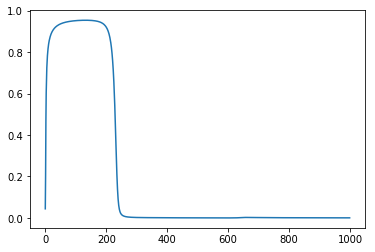

In [22]:
plt.plot(loss)

#Etude a realiser (MNIST)

## Charger les donnees;

In [23]:

from mlxtend.data import loadlocal_mnist
trX, trY = loadlocal_mnist(images_path='train-images-idx3-ubyte', labels_path='train-labels-idx1-ubyte')
teX, teY = loadlocal_mnist(images_path='t10k-images-idx3-ubyte', labels_path='t10k-labels-idx1-ubyte')

In [24]:
X = np.array(trX).reshape(len(trX), -1) > 30
donnee = X*1
labels=np.array(trY)


In [25]:
idx=[i for i in range(len(donnee)) if labels[i] in [0,1,2]]
donnee=donnee[idx]
labels=labels[idx]
labels=enc.fit_transform(np.array(labels).reshape(-1,1))

In [26]:
Pretrained_DBN=init_DBN([donnee.shape[1],200,200,3])
n_iteration   = 10
learning_rate = 0.1
size_batch    = 1024

Pretrained_DBN=train_DBN(Pretrained_DBN, donnee, n_iteration, learning_rate, size_batch)

Layer : 1
Layer : 2
Layer : 3


In [27]:
DBN=init_DBN([donnee.shape[1],200,200,3])
n_iteration   = 200
learning_rate = 0.1
size_batch    = 1024
DNN,loss=train_DNN(DBN, donnee,labels.toarray(), n_iteration, learning_rate, size_batch)

100%|██████████| 200/200 [05:17<00:00,  1.59s/it]


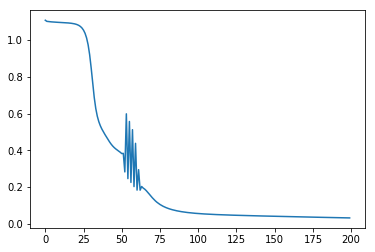

In [28]:
plt.plot(loss)

In [29]:

n_iteration   = 200
learning_rate = 0.1
size_batch    = 256
Pretrained_DNN,Pretrained_loss=train_DNN(Pretrained_DBN, donnee,labels.toarray(), n_iteration, learning_rate, size_batch)

100%|██████████| 200/200 [06:02<00:00,  1.81s/it]


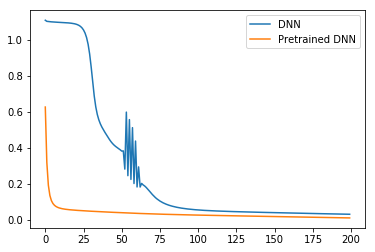

In [30]:
plt.plot(loss,label="DNN")
plt.plot(Pretrained_loss,label="Pretrained DNN")
plt.legend()
plt.show()

In [ ]:
n_iteration   = 10
learning_rate = 0.1
size_batch    = 1024
logs=[]
for k in [2,3,4,5]:
    
    architecure=[donnee.shape[1]]
    for f in range(k):
        architecure.append(200)
    architecure.append(3)
                   
    Pretrained_DBN=init_DBN(architecure)
    Pretrained_DBN=train_DBN(Pretrained_DBN, donnee,n_iteration , learning_rate, size_batch)
    
    DBN=init_DBN(architecure)
    
    DNN,loss=train_DNN(DBN, donnee,labels.toarray(), 200, learning_rate, size_batch)
    pretrained_DNN,pretrained_loss=train_DNN(Pretrained_DBN, donnee,labels.toarray(), 200, learning_rate, size_batch)
    
    logs.append([loss,pretrained_loss])
    plt.plot(loss,label="DNN  Number Of Hidden Layer :"+str(k))
    plt.plot(pretrained_loss,label="Pretrained DNN Number Of Hidden Layer :"+str(k))
 
np.save("logs_fig1",logs)
plt.legend()
plt.show()

Layer : 1
Layer : 2
Layer : 3


 24%|██▎       | 47/200 [01:05<03:37,  1.42s/it]

In [ ]:
logs=np.load("logs_fig1.npy")
plt.figure(figsize=(10,10))
for i in range(len(logs)):
  plt.plot(np.array(logs)[i,0],label="DNN Number Of Hidden Layer : "+str(2+i))
 # plt.plot(np.array(logs)[i,1],label="Pretrained DNN Number Of Hidden Layer : "+str(2+i))

plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(logs)):
 # plt.plot(np.array(logs)[i,0],label="DNN Number Of Hidden Layer : "+str(2+i))
  plt.plot(np.array(logs)[i,1],label="Pretrained DNN Number Of Hidden Layer : "+str(2+i))

plt.legend()
plt.show()

Layer : 1
Layer : 2
Layer : 3


100%|██████████| 200/200 [02:56<00:00,  1.14it/s]


Layer : 1
Layer : 2
Layer : 3


100%|██████████| 200/200 [05:14<00:00,  1.57s/it]


Layer : 1
Layer : 2
Layer : 3


100%|██████████| 200/200 [07:50<00:00,  2.35s/it]


Layer : 1
Layer : 2
Layer : 3


100%|██████████| 200/200 [10:28<00:00,  3.14s/it]


Layer : 1
Layer : 2
Layer : 3


100%|██████████| 200/200 [13:28<00:00,  4.04s/it]


Layer : 1
Layer : 2
Layer : 3


100%|██████████| 200/200 [16:33<00:00,  4.97s/it]


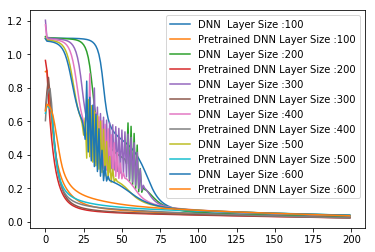

In [32]:

n_iteration   = 10
learning_rate = 0.1
size_batch    = 1024
logs=[]
for size in [100,200,300,400,500,600]:
    architecure=[donnee.shape[1]]
    for f in range(2):
        architecure.append(size)
    architecure.append(3)
                       
    Pretrained_DBN=init_DBN(architecure)
    Pretrained_DBN=train_DBN(Pretrained_DBN, donnee,n_iteration, learning_rate, size_batch)
    
    DBN=init_DBN(architecure)
    
    DNN,loss=train_DNN(DBN, donnee,labels.toarray(), 200, learning_rate, size_batch)
    pretrained_DNN,pretrained_loss=train_DNN(Pretrained_DBN, donnee,labels.toarray(), 200, learning_rate, size_batch)
    
    logs.append([loss,pretrained_loss])
    plt.plot(loss,label="DNN  Layer Size :"+str(size))
    plt.plot(pretrained_loss,label="Pretrained DNN Layer Size :"+str(size))
 
np.save("logs_fig2",logs)
plt.legend()
plt.show()

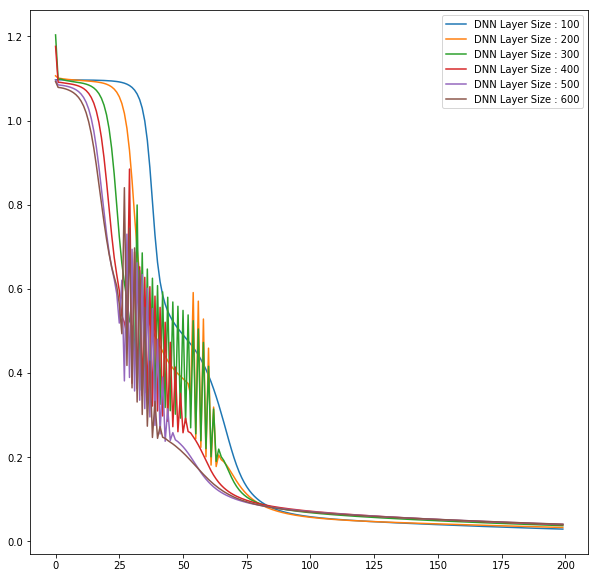

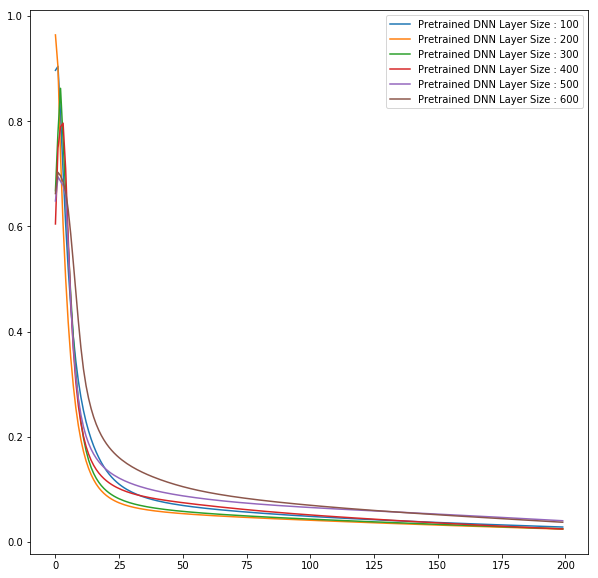

In [33]:
logs=np.load("logs_fig2.npy")
plt.figure(figsize=(10,10))
size=[100,200,300,400,500,600]
for i in range(len(logs)):
  plt.plot(np.array(logs)[i,0],label="DNN Layer Size : "+str(size[i]))
 # plt.plot(np.array(logs)[i,1],label="Pretrained DNN Number Of Hidden Layer : "+str(2+i))

plt.legend()
plt.show()


plt.figure(figsize=(10,10))
for i in range(len(logs)):
 # plt.plot(np.array(logs)[i,0],label="DNN Number Of Hidden Layer : "+str(2+i))
  plt.plot(np.array(logs)[i,1],label="Pretrained DNN Layer Size : "+str(size[i]))

plt.legend()
plt.show()

In [ ]:
from IPython.core.debugger import set_trace
import gzip
import struct

import matplotlib as mpl
import matplotlib.pyplot as plt

# pre-requirement: MNIST data files stored in local directory under $folder/mnist/
# after downloaded from http://yann.lecun.com/exdb/mnist/   
class MnistInput:
    def __init__(self, data):
        if data == "train":
            zX = 'train-images-idx3-ubyte.gz'
            zy = 'train-labels-idx1-ubyte.gz'
        elif data == "test":
            zX = 't10k-images-idx3-ubyte.gz'
            zy = 't10k-labels-idx1-ubyte.gz'
        else: raise ValueError("Incorrect data input")
        
        self.zX = zX
        self.zy = zy
        return
    
    def read(self, num):

        zX = self.zX
        zy = self.zy
        with gzip.open(zX) as fX, gzip.open(zy) as fy:
            magic, nX, rows, cols = struct.unpack(">IIII", fX.read(16))
            magic, ny = struct.unpack(">II", fy.read(8))
            if nX != ny: raise ValueError("Inconsistent data and label files")

            img_size = cols*rows
            if num <= 0 or num > nX: num = nX 
            for i in range(num):
                X = struct.unpack("B"*img_size, fX.read(img_size))
                X = np.array(X).reshape(rows, cols)
                y, = struct.unpack("B", fy.read(1))
                yield (X, y)
        return

In [ ]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

Layer : 1
Layer : 2
Layer : 3


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Layer : 1
Layer : 2
Layer : 3
Layer : 1
Layer : 2
Layer : 3
Layer : 1
Layer : 2
Layer : 3
Layer : 1
Layer : 2
Layer : 3
Layer : 1
Layer : 2
Layer : 3


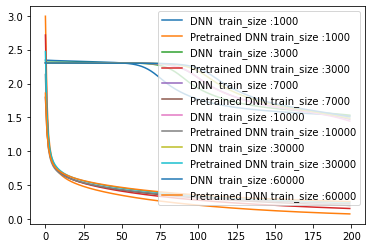

In [ ]:
train_input = MnistInput("train")
    

n_iteration   = 10
learning_rate = 0.1

logs=[]
for train_size in [1000, 3000, 7000, 10000, 30000, 60000]:

    size_batch    = train_size//20
    X = []
    Y = []
    n_x = 0
    for x, y in train_input.read(train_size):
          X.append(x)
          Y.append(y)
          n_x += 1

    X = np.array(X).reshape(n_x, -1) > 30
    donnee = X*1
    labels=np.array(Y)
    
    architecure=[donnee.shape[1]]
    for f in range(2):
        architecure.append(200)
    architecure.append(len(np.unique(labels)))
                   
    Pretrained_DBN=init_DBN(architecure)
    Pretrained_DBN=train_DBN(Pretrained_DBN, donnee,n_iteration , learning_rate, size_batch)
    
    labels_=enc.fit_transform(np.array(labels).reshape(-1,1))
    DBN=init_DBN(architecure)
    
    DNN,loss=train_DNN(DBN, donnee,labels_.toarray(), 200, learning_rate, size_batch)
    pretrained_DNN,pretrained_loss=train_DNN(Pretrained_DBN, donnee,labels_.toarray(), 200, learning_rate, size_batch)
    
    logs.append([loss,pretrained_loss])
    plt.plot(loss,label="DNN  train_size :"+str(train_size))
    plt.plot(pretrained_loss,label="Pretrained DNN train_size :"+str(train_size))
 
np.save("logs_fig3",logs)
plt.legend()
plt.show()

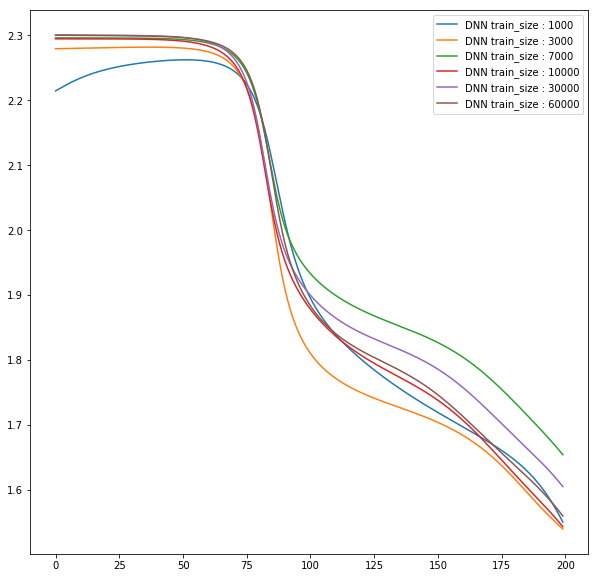

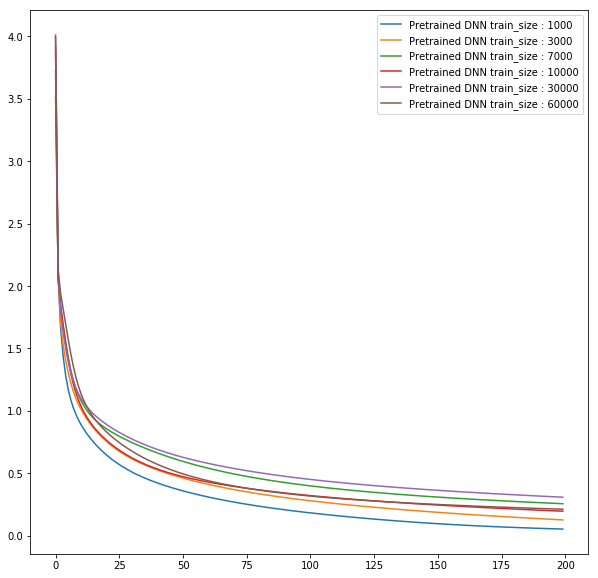

In [34]:
logs=np.load("logs_fig3.npy")
plt.figure(figsize=(10,10))
size=[1000, 3000, 7000, 10000, 30000, 60000]
for i in range(len(logs)):
  plt.plot(np.array(logs)[i,0],label="DNN train_size : "+str(size[i]))
 # plt.plot(np.array(logs)[i,1],label="Pretrained DNN Number Of Hidden Layer : "+str(2+i))

plt.legend()
plt.show()


plt.figure(figsize=(10,10))
for i in range(len(logs)):
 # plt.plot(np.array(logs)[i,0],label="DNN Number Of Hidden Layer : "+str(2+i))
  plt.plot(np.array(logs)[i,1],label="Pretrained DNN train_size : "+str(size[i]))

plt.legend()
plt.show()